# MODELOS CNN TENSORFLOW CON CPU

## Carga de datos y de librerías

### Librerías

In [1]:
# Módulos de Astropy
from astropy.io import fits
from astropy.table import Table

# Módulos de visualización y cálculo numérico
import matplotlib.pyplot as plt
import numpy as np

# Módulos de sklearn para división de datos y búsqueda en grilla
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Módulos de TensorFlow y TensorFlow Addons
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Activation, LeakyReLU
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

# Módulo de itertools para la generación de productos cartesianos
from itertools import product

import os
import sys

from matplotlib import colors
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model
from matplotlib import colors

from sklearn.metrics import roc_curve, auc

2023-05-10 21:06:30.796115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 21:06:30.923571: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-10 21:06:31.413885: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-05-10 21:06:31.413943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot

### Datos

#### Crear label

In [2]:
# ruta_carpeta_resultados = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 2/labels"
# archivos = os.listdir(ruta_carpeta_resultados)

# def clamp(value, min_value, max_value):
#     return max(min(value, max_value), min_value)

# def procesar_archivo(path_txt):
#     with open(path_txt, "r") as f:
#         lines = f.readlines()

#     label = np.zeros((2048, 2048), dtype=int)

#     for line in lines:
#         x, y, _ = line.split()
#         x, y = int(float(x)), int(float(y))

#         for i in range(-4, 4):
#             for j in range(-4, 4):
#                 x_coord = clamp(x + i, 0, 2047)
#                 y_coord = clamp(y + j, 0, 2047)
#                 label[y_coord, x_coord] = 1

#     return label

# # Crear una lista para guardar los datos procesados
# output_data=[]

# # Procesar todos los archivos de texto en la carpeta de resultados
# for archivo in archivos:
#     path_txt = os.path.join(ruta_carpeta_resultados, archivo)
#     label = procesar_archivo(path_txt)
#     output_data.append(label)


# fits.HDUList([fits.PrimaryHDU(output_data)]).writeto('/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 2/fit/LABEL_COMPLETO_V2.fit', overwrite=True)


#### Carga de datos

In [4]:
# Cargar los datos a partir de los archivos FITS

#imagenes
path_datos = "/home/21953404Victor/SDC3/SDC3GIT/data_actualizada/"
path = path_datos + "ZW3.msw_image.fits"
hdul = fits.open(path)
#label
output_data = fits.open('/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 2/fit/LABEL_COMPLETO_V2.fit')[0].data

In [44]:
def plot_history(history, title="", show=True):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Gráfico de precisión
    axes[0].plot(history.history["accuracy"], label="Entrenamiento")
    axes[0].plot(history.history["val_accuracy"], label="Validación")
    axes[0].set_xlabel("Épocas")
    axes[0].set_ylabel("Precisión")
    axes[0].set_title("Precisión - " + title)
    axes[0].legend()

    # Gráfico de pérdida
    axes[1].plot(history.history["loss"], label="Entrenamiento")
    axes[1].plot(history.history["val_loss"], label="Validación")
    axes[1].set_xlabel("Épocas")
    axes[1].set_ylabel("Pérdida")
    axes[1].set_title("Pérdida - " + title)
    axes[1].legend()

    if show:
        plt.show()

## Modelo 1

In [23]:
num_samples = 400
indices = np.random.choice(hdul[0].data.shape[0], num_samples, replace=False)
output_data = np.array(output_data)[indices]

# Guardar los índices en un archivo de texto
def save_indices_to_txt(indices, filename="indices.txt"):
    np.savetxt(filename, indices, fmt='%d')
save_indices_to_txt(indices, "indices_cnn_completa_1.txt")

# Cargar los datos utilizando una vista de las filas seleccionadas
data = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0

# Establecer una semilla para asegurar la reproducibilidad de la partición
np.random.seed(40)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data, output_data, test_size=0.2, random_state=40)

# Eliminar data y output_data para liberar memoria
del data
del output_data


In [24]:
# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 instance_normalization (Ins  (None, 2048, 2048, 32)   64        
 tanceNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 32)    9248      
                                                                 
 instance_normalization_1 (I  (None, 1024, 1024, 32)   64        
 nstanceNormalization)                                           
                                                        

Epoch 1/5


2023-04-27 15:24:32.432360: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5368709120 exceeds 10% of free system memory.
2023-04-27 15:24:34.023385: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 10737418240 exceeds 10% of free system memory.
2023-04-27 15:24:39.520519: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4831838208 exceeds 10% of free system memory.
2023-04-27 15:24:39.525447: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4831838208 exceeds 10% of free system memory.


  1/160 [..............................] - ETA: 20:17 - loss: 0.6931 - accuracy: 0.2586

2023-04-27 15:24:45.452402: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4831838208 exceeds 10% of free system memory.


160/160 [==============================] - 970s 6s/step - loss: 0.1512 - accuracy: 0.9703 - val_loss: 0.0672 - val_accuracy: 0.9800
Epoch 2/5
160/160 [==============================] - 966s 6s/step - loss: 0.0627 - accuracy: 0.9815 - val_loss: 0.0567 - val_accuracy: 0.9832
Epoch 3/5
160/160 [==============================] - 973s 6s/step - loss: 0.0607 - accuracy: 0.9824 - val_loss: 0.0538 - val_accuracy: 0.9837
Epoch 4/5
160/160 [==============================] - 983s 6s/step - loss: 0.0593 - accuracy: 0.9828 - val_loss: 0.0541 - val_accuracy: 0.9828
Epoch 5/5
160/160 [==============================] - 999s 6s/step - loss: 0.0562 - accuracy: 0.9831 - val_loss: 0.0566 - val_accuracy: 0.9836


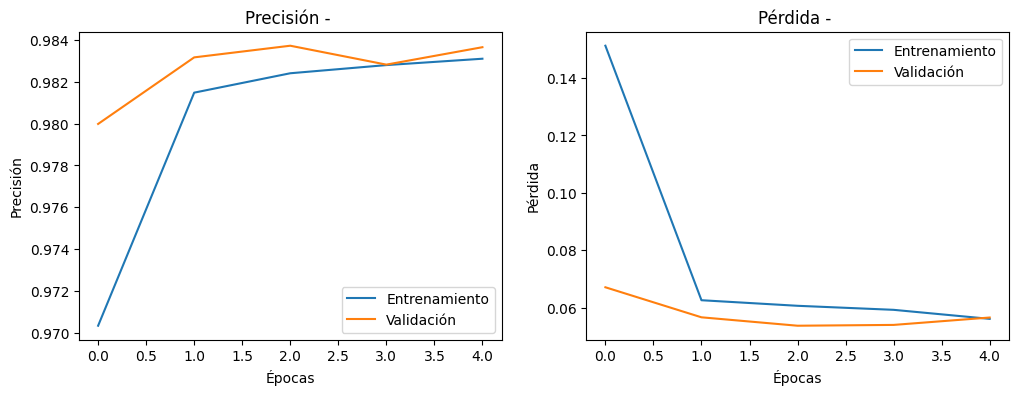

In [11]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=5, batch_size=2, validation_data=(x_val, y_val))
model.save("cnn-cpu-completa-1.h5")
plot_history(history)

### AUC DEL MODELO 1

In [28]:
# Cargar el modelo guardado
model = load_model("cnn-cpu-completa-1.h5")

# Cargar los índices guardados previamente
def load_indices_from_txt(filename="indices.txt"):
    return np.loadtxt(filename, dtype=int)

indices = load_indices_from_txt("indices_cnn_completa_1.txt")

In [29]:
# Cargar los datos utilizando una vista de las filas seleccionadas
data_m1 = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0
output_data_m1 = np.array(output_data)[indices]

# Establecer una semilla para asegurar la reproducibilidad de la partición
np.random.seed(40)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data_m1, output_data_m1, test_size=0.2, random_state=40)

# Crear listas para almacenar las predicciones y los valores reales
y_val_pred_probs_list = []
y_val_list = []

# Establecer el tamaño del lote
batch_size = 10

del data_m1
del output_data_m1

In [30]:
y_val_pred_probs = model.predict(x_val, batch_size=batch_size)

2023-05-07 16:45:20.684763: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5368709120 exceeds 10% of free system memory.
2023-05-07 16:45:21.108497: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5368709120 exceeds 10% of free system memory.
2023-05-07 16:45:22.869253: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5368709120 exceeds 10% of free system memory.


1/8 [==>...........................] - ETA: 24s

2023-05-07 16:45:23.387828: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5368709120 exceeds 10% of free system memory.
2023-05-07 16:45:23.776361: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5368709120 exceeds 10% of free system memory.


8/8 [==============================] - 22s 3s/step


Umbral: 0.5
Verdaderos positivos: 4512648
Falsos positivos: 817154
Falsos negativos: 4808129
Verdaderos negativos: 325406389
Umbral: 0.6
Verdaderos positivos: 4013449
Falsos positivos: 619576
Falsos negativos: 5307328
Verdaderos negativos: 325603967
Umbral: 0.7
Verdaderos positivos: 3468318
Falsos positivos: 470382
Falsos negativos: 5852459
Verdaderos negativos: 325753161
Umbral: 0.8
Verdaderos positivos: 2843094
Falsos positivos: 337111
Falsos negativos: 6477683
Verdaderos negativos: 325886432
Umbral: 0.9
Verdaderos positivos: 2003373
Falsos positivos: 187068
Falsos negativos: 7317404
Verdaderos negativos: 326036475
Umbral: 0.95
Verdaderos positivos: 1384523
Falsos positivos: 88965
Falsos negativos: 7936254
Verdaderos negativos: 326134578


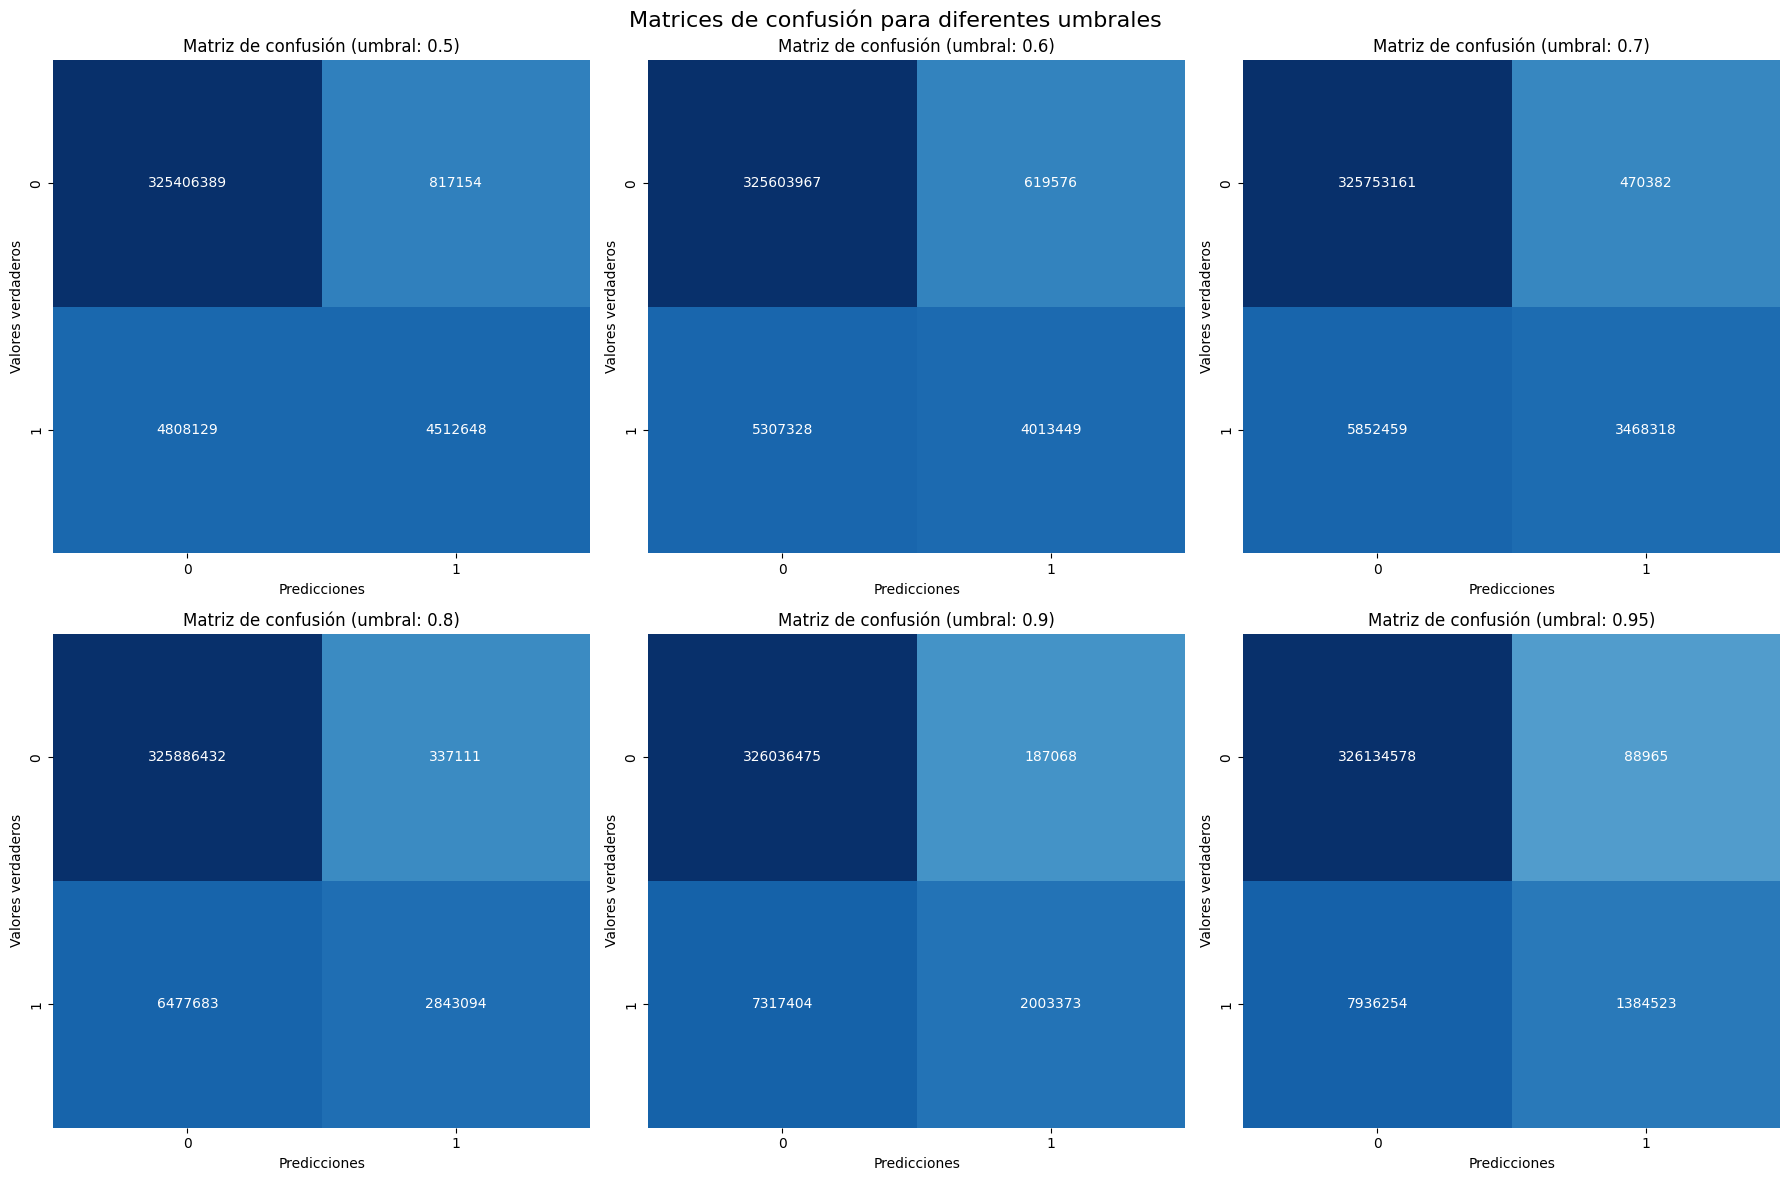

In [36]:
y_val_1d = y_val.flatten()
y_val_pred_probs_1d = y_val_pred_probs.flatten()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for idx, threshold in enumerate([0.5, 0.6, 0.7, 0.8, 0.9, 0.95]):
    y_val_pred_labels_1d = (y_val_pred_probs_1d > threshold).astype(int)
    conf_matrix = confusion_matrix(y_val_1d, y_val_pred_labels_1d)
    ax = axes[idx // 3, idx % 3]
    log_norm = colors.LogNorm(vmin=1, vmax=conf_matrix.max())
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, norm=log_norm)
    ax.set_title(f"Matriz de confusión (umbral: {threshold})")
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Valores verdaderos')
    # Etiquetas de valores de matriz de confusión
    print( f"Umbral: {threshold}")
    print( f"Verdaderos positivos: {conf_matrix[1, 1]}")
    print( f"Falsos positivos: {conf_matrix[0, 1]}")
    print( f"Falsos negativos: {conf_matrix[1, 0]}")
    print( f"Verdaderos negativos: {conf_matrix[0, 0]}")

fig.suptitle('Matrices de confusión para diferentes umbrales', fontsize=16)
plt.tight_layout()
plt.show()

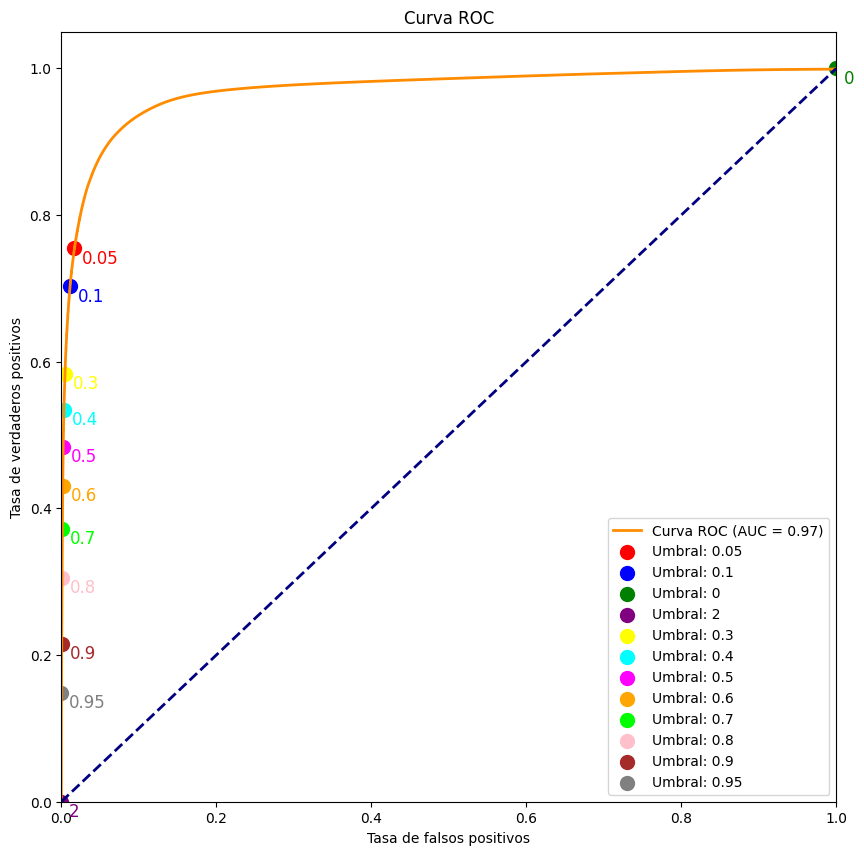

In [40]:
fpr, tpr, thresholds = roc_curve(y_val_1d, y_val_pred_probs_1d)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# Agregar puntos de diferentes umbrales en la curva ROC
thresholds_to_plot = [0.05, 0.1, 0,2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'cyan', 'magenta', 'orange', 'lime', 'pink', 'brown', 'gray']

for threshold, color in zip(thresholds_to_plot, colors):
    idx = (np.abs(thresholds - threshold)).argmin()
    plt.scatter(fpr[idx], tpr[idx], color=color, s=100, label=f"Umbral: {threshold}")
    plt.text(fpr[idx] + 0.01, tpr[idx] - 0.02, f"{threshold}", fontsize=12, color=color)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

## Modelo 2

In [17]:
num_samples = 500
indices = np.random.choice(hdul[0].data.shape[0], num_samples, replace=False)
output_data = np.array(output_data)[indices]

# Guardar los índices en un archivo de texto
def save_indices_to_txt(indices, filename="indices.txt"):
    np.savetxt(filename, indices, fmt='%d')
save_indices_to_txt(indices, "indices_cnn_completa_2.txt")

# Cargar los datos utilizando una vista de las filas seleccionadas
data = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0

# Establecer una semilla para asegurar la reproducibilidad de la partición
np.random.seed(41)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data, output_data, test_size=0.2, random_state=41)

# Eliminar data y output_data para liberar memoria
del data
del output_data

In [6]:
# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
# Inicializar Adam con una tasa de aprendizaje de 0.0001
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

2023-04-28 15:04:14.454825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 15:04:14.459021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-04-28 15:04:14.459034: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-28 15:04:14.459637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 instance_normalization (Ins  (None, 2048, 2048, 32)   64        
 tanceNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 32)    9248      
                                                                 
 instance_normalization_1 (I  (None, 1024, 1024, 32)   64        
 nstanceNormalization)                                           
                                                        

/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/8


2023-04-28 15:04:17.021355: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13421772800 exceeds 10% of free system memory.


200/200 [==============================] - 1232s 6s/step - loss: 0.3699 - accuracy: 0.9678 - val_loss: 0.1088 - val_accuracy: 0.9741
Epoch 2/8
200/200 [==============================] - 1230s 6s/step - loss: 0.0998 - accuracy: 0.9756 - val_loss: 0.0930 - val_accuracy: 0.9762
Epoch 3/8
200/200 [==============================] - 1235s 6s/step - loss: 0.0822 - accuracy: 0.9777 - val_loss: 0.0765 - val_accuracy: 0.9784
Epoch 4/8
200/200 [==============================] - 1237s 6s/step - loss: 0.0691 - accuracy: 0.9798 - val_loss: 0.0662 - val_accuracy: 0.9803
Epoch 5/8
200/200 [==============================] - 1240s 6s/step - loss: 0.0622 - accuracy: 0.9813 - val_loss: 0.0673 - val_accuracy: 0.9806
Epoch 6/8
200/200 [==============================] - 1242s 6s/step - loss: 0.0596 - accuracy: 0.9819 - val_loss: 0.0620 - val_accuracy: 0.9811
Epoch 7/8
200/200 [==============================] - 1244s 6s/step - loss: 0.0575 - accuracy: 0.9824 - val_loss: 0.0585 - val_accuracy: 0.9819
Epoch 8/8

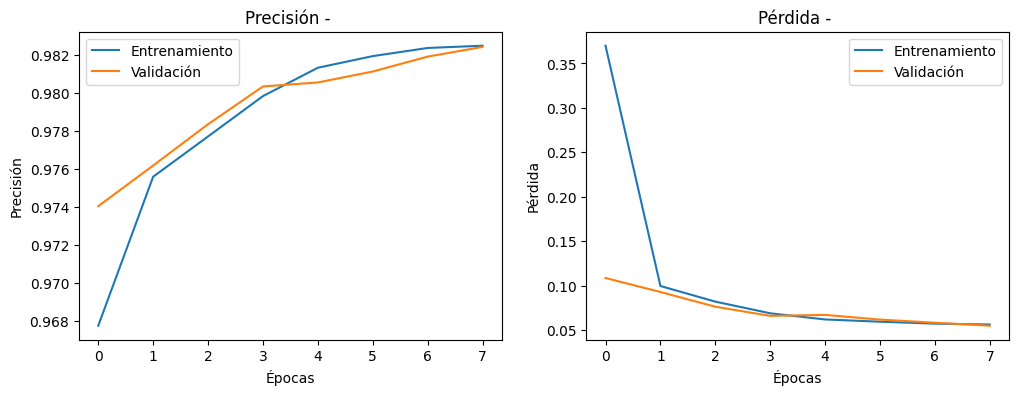

In [7]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=8, batch_size=2, validation_data=(x_val, y_val))
model.save("cnn-cpu-completa-2.h5")
plot_history(history)

### AUC DEL MODELO 2

In [45]:
# Cargar el modelo guardado
model = load_model("cnn-cpu-completa-2.h5")

# Cargar los índices guardados previamente
def load_indices_from_txt(filename="indices.txt"):
    return np.loadtxt(filename, dtype=int)

indices = load_indices_from_txt("indices_cnn_completa_2.txt")

In [46]:
# Cargar los datos utilizando una vista de las filas seleccionadas
data_m2 = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0
output_data_m2 = np.array(output_data)[indices]

# Establecer una semilla para asegurar la reproducibilidad de la partición
np.random.seed(41)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data_m2, output_data_m2, test_size=0.2, random_state=41)

# Crear listas para almacenar las predicciones y los valores reales
y_val_pred_probs_list = []
y_val_list = []

# Establecer el tamaño del lote
batch_size = 10

del data_m2
del output_data_m2

In [47]:
y_val_pred_probs = model.predict(x_val, batch_size=batch_size)

10/10 [==============================] - 28s 3s/step


Umbral: 0.5
Verdaderos positivos: 5797571
Falsos positivos: 1511203
Falsos negativos: 5924619
Verdaderos negativos: 406197007
Umbral: 0.6
Verdaderos positivos: 5138125
Falsos positivos: 1087958
Falsos negativos: 6584065
Verdaderos negativos: 406620252
Umbral: 0.7
Verdaderos positivos: 4423255
Falsos positivos: 798457
Falsos negativos: 7298935
Verdaderos negativos: 406909753
Umbral: 0.8
Verdaderos positivos: 3602914
Falsos positivos: 577322
Falsos negativos: 8119276
Verdaderos negativos: 407130888
Umbral: 0.9
Verdaderos positivos: 2526872
Falsos positivos: 359003
Falsos negativos: 9195318
Verdaderos negativos: 407349207
Umbral: 0.95
Verdaderos positivos: 1728464
Falsos positivos: 217377
Falsos negativos: 9993726
Verdaderos negativos: 407490833


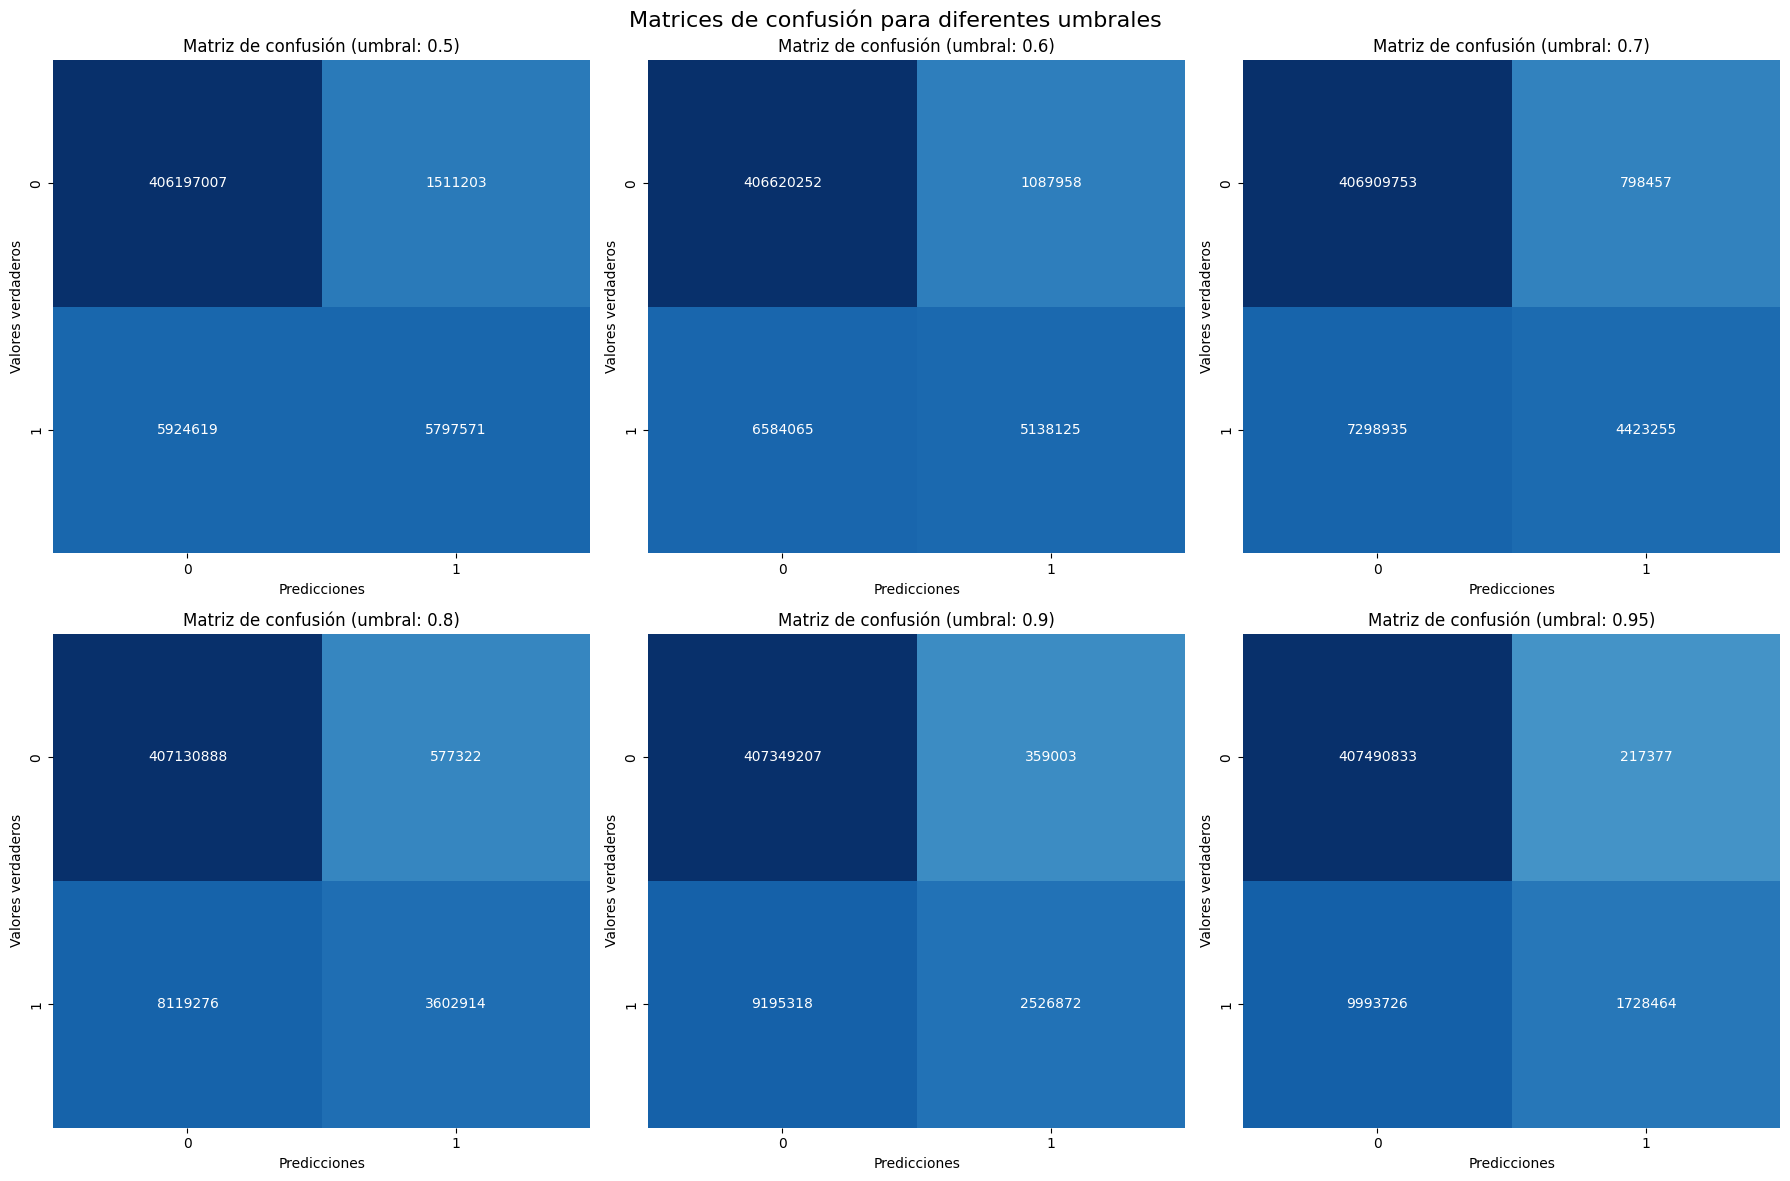

In [48]:
y_val_1d = y_val.flatten()
y_val_pred_probs_1d = y_val_pred_probs.flatten()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for idx, threshold in enumerate([0.5, 0.6, 0.7, 0.8, 0.9, 0.95]):
    y_val_pred_labels_1d = (y_val_pred_probs_1d > threshold).astype(int)
    conf_matrix = confusion_matrix(y_val_1d, y_val_pred_labels_1d)
    ax = axes[idx // 3, idx % 3]
    log_norm = colors.LogNorm(vmin=1, vmax=conf_matrix.max())
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, norm=log_norm)
    ax.set_title(f"Matriz de confusión (umbral: {threshold})")
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Valores verdaderos')
    # Etiquetas de valores de matriz de confusión
    print( f"Umbral: {threshold}")
    print( f"Verdaderos positivos: {conf_matrix[1, 1]}")
    print( f"Falsos positivos: {conf_matrix[0, 1]}")
    print( f"Falsos negativos: {conf_matrix[1, 0]}")
    print( f"Verdaderos negativos: {conf_matrix[0, 0]}")

fig.suptitle('Matrices de confusión para diferentes umbrales', fontsize=16)
plt.tight_layout()
plt.show()

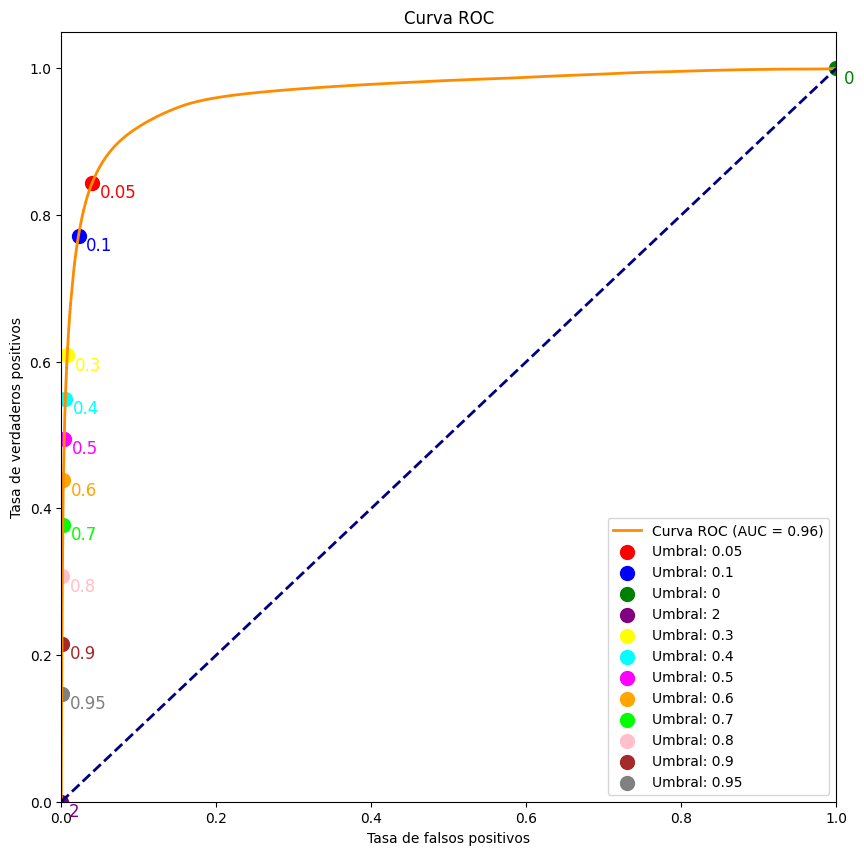

In [49]:
fpr, tpr, thresholds = roc_curve(y_val_1d, y_val_pred_probs_1d)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# Agregar puntos de diferentes umbrales en la curva ROC
thresholds_to_plot = [0.05, 0.1, 0,2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'cyan', 'magenta', 'orange', 'lime', 'pink', 'brown', 'gray']

for threshold, color in zip(thresholds_to_plot, colors):
    idx = (np.abs(thresholds - threshold)).argmin()
    plt.scatter(fpr[idx], tpr[idx], color=color, s=100, label=f"Umbral: {threshold}")
    plt.text(fpr[idx] + 0.01, tpr[idx] - 0.02, f"{threshold}", fontsize=12, color=color)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

## Modelo 3

In [5]:
num_samples = 500
indices = np.random.choice(hdul[0].data.shape[0], num_samples, replace=False)
output_data = np.array(output_data)[indices]

# Guardar los índices en un archivo de texto
def save_indices_to_txt(indices, filename="indices.txt"):
    np.savetxt(filename, indices, fmt='%d')
save_indices_to_txt(indices, "indices_cnn_completa_3.txt")

# Cargar los datos utilizando una vista de las filas seleccionadas
data = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0

# Establecer una semilla para asegurar la reproducibilidad de la partición
np.random.seed(42)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data, output_data, test_size=0.2, random_state=42)

# Eliminar data y output_data para liberar memoria
del data
del output_data


In [6]:
# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
# Inicializar Adam con una tasa de aprendizaje de 0.0001
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

2023-05-04 12:21:57.887434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-04 12:21:57.897052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-05-04 12:21:57.897067: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-04 12:21:57.897450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 instance_normalization (Ins  (None, 2048, 2048, 32)   64        
 tanceNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 32)    9248      
                                                                 
 instance_normalization_1 (I  (None, 1024, 1024, 32)   64        
 nstanceNormalization)                                           
                                                        

/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2023-05-04 12:21:58.286709: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6710886400 exceeds 10% of free system memory.


Epoch 1/65


2023-05-04 12:22:00.415965: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13421772800 exceeds 10% of free system memory.


200/200 [==============================] - 1222s 6s/step - loss: 0.1405 - accuracy: 0.9707 - val_loss: 0.0715 - val_accuracy: 0.9795
Epoch 2/65
200/200 [==============================] - 1212s 6s/step - loss: 0.0626 - accuracy: 0.9813 - val_loss: 0.0543 - val_accuracy: 0.9828
Epoch 3/65
200/200 [==============================] - 1224s 6s/step - loss: 0.0614 - accuracy: 0.9822 - val_loss: 0.0526 - val_accuracy: 0.9834
Epoch 4/65
200/200 [==============================] - 1229s 6s/step - loss: 0.0568 - accuracy: 0.9829 - val_loss: 0.0597 - val_accuracy: 0.9830
Epoch 5/65
200/200 [==============================] - 1233s 6s/step - loss: 0.0539 - accuracy: 0.9835 - val_loss: 0.0494 - val_accuracy: 0.9843
Epoch 6/65
200/200 [==============================] - 1236s 6s/step - loss: 0.0524 - accuracy: 0.9838 - val_loss: 0.0480 - val_accuracy: 0.9845
Epoch 7/65
200/200 [==============================] - 1239s 6s/step - loss: 0.0533 - accuracy: 0.9839 - val_loss: 0.0511 - val_accuracy: 0.9841
Epo

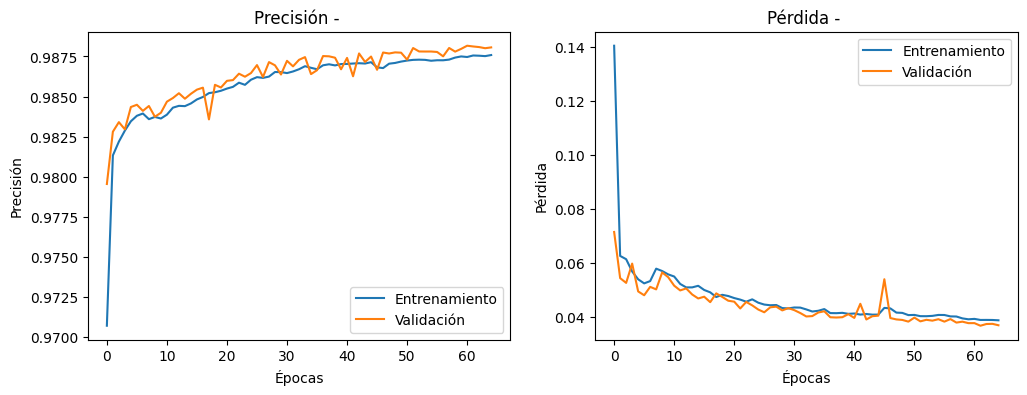

In [7]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=65, batch_size=2, validation_data=(x_val, y_val))
model.save("cnn-cpu-completa-3.h5")
plot_history(history)

### AUC DEL MODELO 3

In [6]:
# Cargar el modelo guardado
model = load_model("cnn-cpu-completa-3.h5")

# Cargar los índices guardados previamente
def load_indices_from_txt(filename="indices.txt"):
    return np.loadtxt(filename, dtype=int)

indices = load_indices_from_txt("indices_cnn_completa_3.txt")

2023-05-07 10:28:41.989241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-07 10:28:41.997314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-05-07 10:28:41.997326: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-05-07 10:28:41.997679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with 

In [7]:
# Cargar los datos utilizando una vista de las filas seleccionadas
data_m3 = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0
output_data_m3 = np.array(output_data)[indices]

# Establecer una semilla para asegurar la reproducibilidad de la partición
np.random.seed(42)

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data_m3, output_data_m3, test_size=0.2, random_state=42)

# Crear listas para almacenar las predicciones y los valores reales
y_val_pred_probs_list = []
y_val_list = []

# Establecer el tamaño del lote
batch_size = 10

del data_m3
del output_data_m3

In [31]:
y_val_pred_probs = model.predict(x_val, batch_size=batch_size)

10/10 [==============================] - 26s 3s/step


Umbral: 0.5
Verdaderos positivos: 8088047
Falsos positivos: 1405313
Falsos negativos: 3600446
Verdaderos negativos: 406336594
Umbral: 0.6
Verdaderos positivos: 7444700
Falsos positivos: 988417
Falsos negativos: 4243793
Verdaderos negativos: 406753490
Umbral: 0.7
Verdaderos positivos: 6678157
Falsos positivos: 666552
Falsos negativos: 5010336
Verdaderos negativos: 407075355
Umbral: 0.8
Verdaderos positivos: 5669162
Falsos positivos: 391423
Falsos negativos: 6019331
Verdaderos negativos: 407350484
Umbral: 0.9
Verdaderos positivos: 4163749
Falsos positivos: 156099
Falsos negativos: 7524744
Verdaderos negativos: 407585808
Umbral: 0.95
Verdaderos positivos: 2950985
Falsos positivos: 66998
Falsos negativos: 8737508
Verdaderos negativos: 407674909


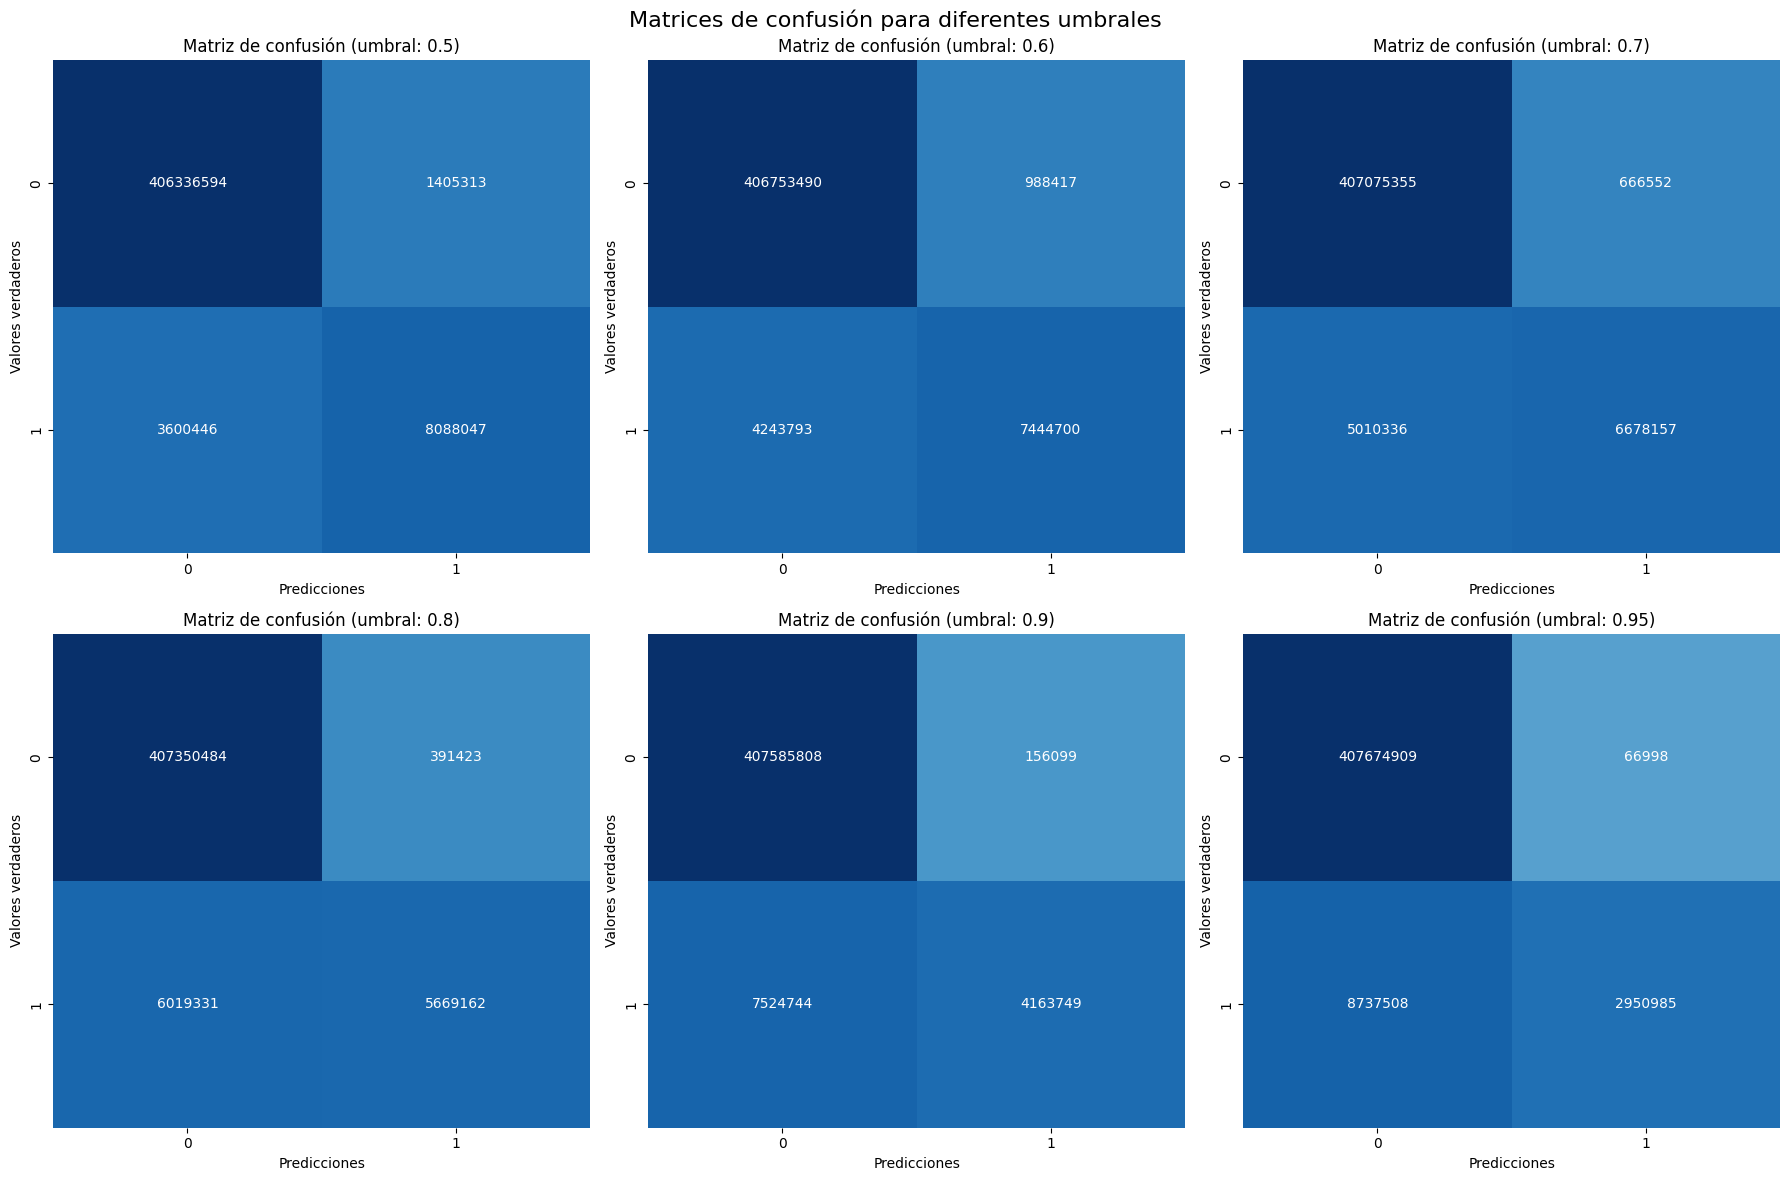

In [68]:
y_val_1d = y_val.flatten()
y_val_pred_probs_1d = y_val_pred_probs.flatten()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
for idx, threshold in enumerate([0.5, 0.6, 0.7, 0.8, 0.9, 0.95]):
    y_val_pred_labels_1d = (y_val_pred_probs_1d > threshold).astype(int)
    conf_matrix = confusion_matrix(y_val_1d, y_val_pred_labels_1d)
    ax = axes[idx // 3, idx % 3]
    log_norm = colors.LogNorm(vmin=1, vmax=conf_matrix.max())
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False, norm=log_norm)
    ax.set_title(f"Matriz de confusión (umbral: {threshold})")
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Valores verdaderos')
    # Etiquetas de valores de matriz de confusión
    print( f"Umbral: {threshold}")
    print( f"Verdaderos positivos: {conf_matrix[1, 1]}")
    print( f"Falsos positivos: {conf_matrix[0, 1]}")
    print( f"Falsos negativos: {conf_matrix[1, 0]}")
    print( f"Verdaderos negativos: {conf_matrix[0, 0]}")

fig.suptitle('Matrices de confusión para diferentes umbrales', fontsize=16)
plt.tight_layout()
plt.show()

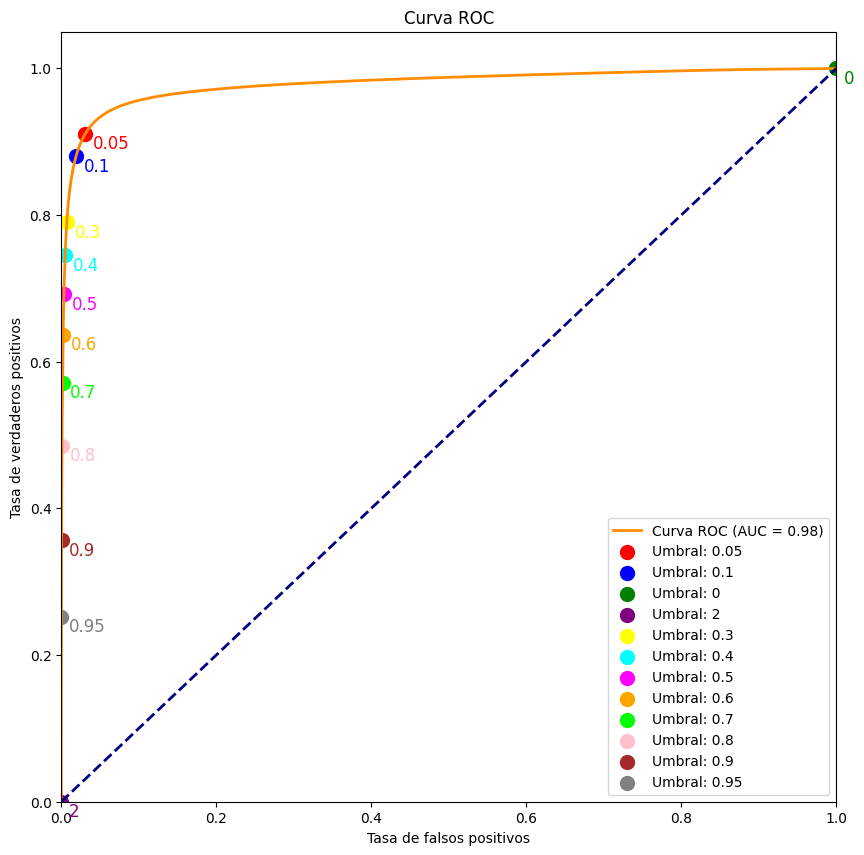

In [60]:
fpr, tpr, thresholds = roc_curve(y_val_1d, y_val_pred_probs_1d)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# Agregar puntos de diferentes umbrales en la curva ROC
thresholds_to_plot = [0.05, 0.1, 0,2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'cyan', 'magenta', 'orange', 'lime', 'pink', 'brown', 'gray']

for threshold, color in zip(thresholds_to_plot, colors):
    idx = (np.abs(thresholds - threshold)).argmin()
    plt.scatter(fpr[idx], tpr[idx], color=color, s=100, label=f"Umbral: {threshold}")
    plt.text(fpr[idx] + 0.01, tpr[idx] - 0.02, f"{threshold}", fontsize=12, color=color)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()
